# Notes on Hierarchical Hilbert Space Gaussian Processes

In this notebook, we want to explore some ideas on hierarchical Hilbert Space Gaussian Processes following the fantastic exposition of the PyMC example notebook: ["Gaussian Processes: HSGP Advanced Usage"](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/HSGP-Advanced.html) by [Bill Engels](https://github.com/bwengals), [Alexandre Andorra](https://github.com/AlexAndorra) and [Maxim Kochurov](https://github.com/ferrine). I can only recommend to read the notebook and the references therein!
For an introduction to Hilbert Space Gaussian Processes, please see my introductory blog post: ["A Conceptual and Practical Introduction to Hilbert Space GPs Approximation Methods"](https://juanitorduz.github.io/hsgp_intro/).

**Motivation**: In many applications, one is interested in understanding the dynamic effect of one variable on another. For example, in marketing, one is interested in efficiency across many channels on sales (or conversions) as a function of time. For such a purpose, one typically uses a time-varying regression model with time-varying coefficients (for a simple example, see ["Time-Varying Regression Coefficients via Hilbert Space Gaussian Process Approximation"](https://juanitorduz.github.io/bikes_gp/)). The main challenge is that, if not done carefully, the model will easily overfit the data. One can use a hierarchical model with a global component and a group-specific component to overcome this. The global component will capture the overall trend, while the group-specific component will capture the idiosyncratic behavior of each group. As a side effect, we will gain some regularization effect that will help to avoid overfitting. For the marketing example above, [PyMC Labs](https://www.pymc-labs.com/blog-posts/) has successfully applied this approach in the context of media mix modeling: ["Bayesian Media Mix Models: Modelling changes in marketing effectiveness over time"](https://www.pymc-labs.com/blog-posts/modelling-changes-marketing-effectiveness-over-time/). This hierarchical approach was motivated by the work ["Hierarchical Bayesian modeling of gene expression time series across irregularly sampled replicates and clusters"](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-252).

To my knowledge (please correct me if I am wrong), the PyMC example notebook ["Gaussian Processes: HSGP Advanced Usage"](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/HSGP-Advanced.html) is the first reference with complete code to fit a hierarchical Hilbert Space Gaussian Process (well, maybe the [initial gist](https://gist.github.com/bwengals/90e79d64fe9e2d496a048f0b2c6d33da)). Here, we use very similar techniques with NumPyro using the (relatively) new [Hilbert Space Gaussian Process module](https://num.pyro.ai/en/latest/contrib.html#hilbert-space-gaussian-processes-approximation). For both the PyMC and NumPyro implementations, one of the key ingredients is vectorizing the spectral density expressions (as we need to fit many groups). While in the PyMC notebook, the vectorization is done by hand, in the NumPyro implementation, the vectorization is done using the [vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) function. Nevertheless, both approaches are equivalent. Hence, we can focus on the concepts and worry less about the implementation details.

With these new explicit code references, we expect to demystify the implementation of the hierarchical Hilbert Space Gaussian Process so that the community can benefit from this approach for real applications. That being said, as we will see below, this approach has its challenges. As in many applications with Gaussian processes, specifying sensitive priors and ensuring parameter identifiability is not a trivial task. Here is where the application should drive the model specification (where the thinking happens!).


## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import preliz as pz
from jax import random, vmap
from jax.nn import softplus
from jaxtyping import Array, Float32, UInt32
from numpyro.contrib.hsgp.approximation import hsgp_squared_exponential
from numpyro.contrib.hsgp.laplacian import eigenfunctions
from numpyro.contrib.hsgp.spectral_densities import (
    diag_spectral_density_squared_exponential,
)
from numpyro.handlers import condition, scope
from numpyro.infer import MCMC, NUTS, Predictive
from xarray import DataArray  # noqa: F401

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Generate Synthetic Data

We start by generating some synthetic data. We do not do a full parameter recovery as in the PyMC notebook. Instead, we simple generate synthetic data, fit and asses the quality of the model.  We will use a single group-specific latent function for each group. The mean function is a sum of two sine waves.

In [2]:
def generate_single_group_data(
    rng_key: UInt32[Array, "2"], x: Float32[Array, " n"]
) -> Float32[Array, " n"]:
    """Generate one dimensional data for a single group.

    Parameters
    ----------
    rng_key : UInt32[Array, "2"]
        JAX random key.
    x : Float32[Array, " n"]
        Input domain data.

    Returns
    -------
    Float32[Array, " n"]
        Output data.
    """
    a1, a2, a3, a4 = random.uniform(rng_key, minval=4, maxval=7, shape=(4,))
    return (
        jnp.sin((a1 * jnp.pi) * x)
        + jnp.cos((a2 * jnp.pi) * x)
        - jnp.sin((a3 * 2 * jnp.pi) * x)
        + jnp.sin((a4 * 3 * jnp.pi) * x)
    )


def dgg(
    rng_key: UInt32[Array, "2"], x: Float32[Array, " n"]
) -> tuple[Float32[Array, " n"], Float32[Array, " n"], Float32[Array, " n"]]:
    """Data generation function.

    We generate data for a single group by adding noise to the mean latent function.

    y = f + f_g + noise

    where:
    - f is the mean function (GP)
    - f_g is the group-specific latent function (GP)
    - noise is i.i.d. Gaussian noise

    Parameters
    ----------
    rng_key : UInt32[Array, "2"]
        JAX random key.
    x : Float32[Array, " n"]
        Input domain data.

    Returns
    -------
    tuple[Float32[Array, " n"], Float32[Array, " n"], Float32[Array, " n"]]
        Group-specific latent function, mean function and observed data.
    """
    n = x.shape[0]
    f_g = generate_single_group_data(rng_key, x)
    f = jnp.sin((4 * jnp.pi) * x) + jnp.sin((1 * jnp.pi) * x)
    noise = random.normal(rng_key, shape=(n,)) * 0.5
    y = f + f_g + noise
    return f_g, f, y


# Number of observations and groups
n = 300
n_groups = 5

# Input domain data
x = jnp.linspace(0.1, 1, n)

# Generate data
rng_key, rng_subkey = random.split(rng_key)

# Generate data for each group
f_g, f, y = vmap(dgg)(
    random.split(rng_subkey, n_groups), jnp.tile(x, reps=(n_groups, 1))
)

# Check shapes
assert f_g.shape == (n_groups, n)
assert f.shape == (n_groups, n)
assert y.shape == (n_groups, n)

Let's visualize the raw data.

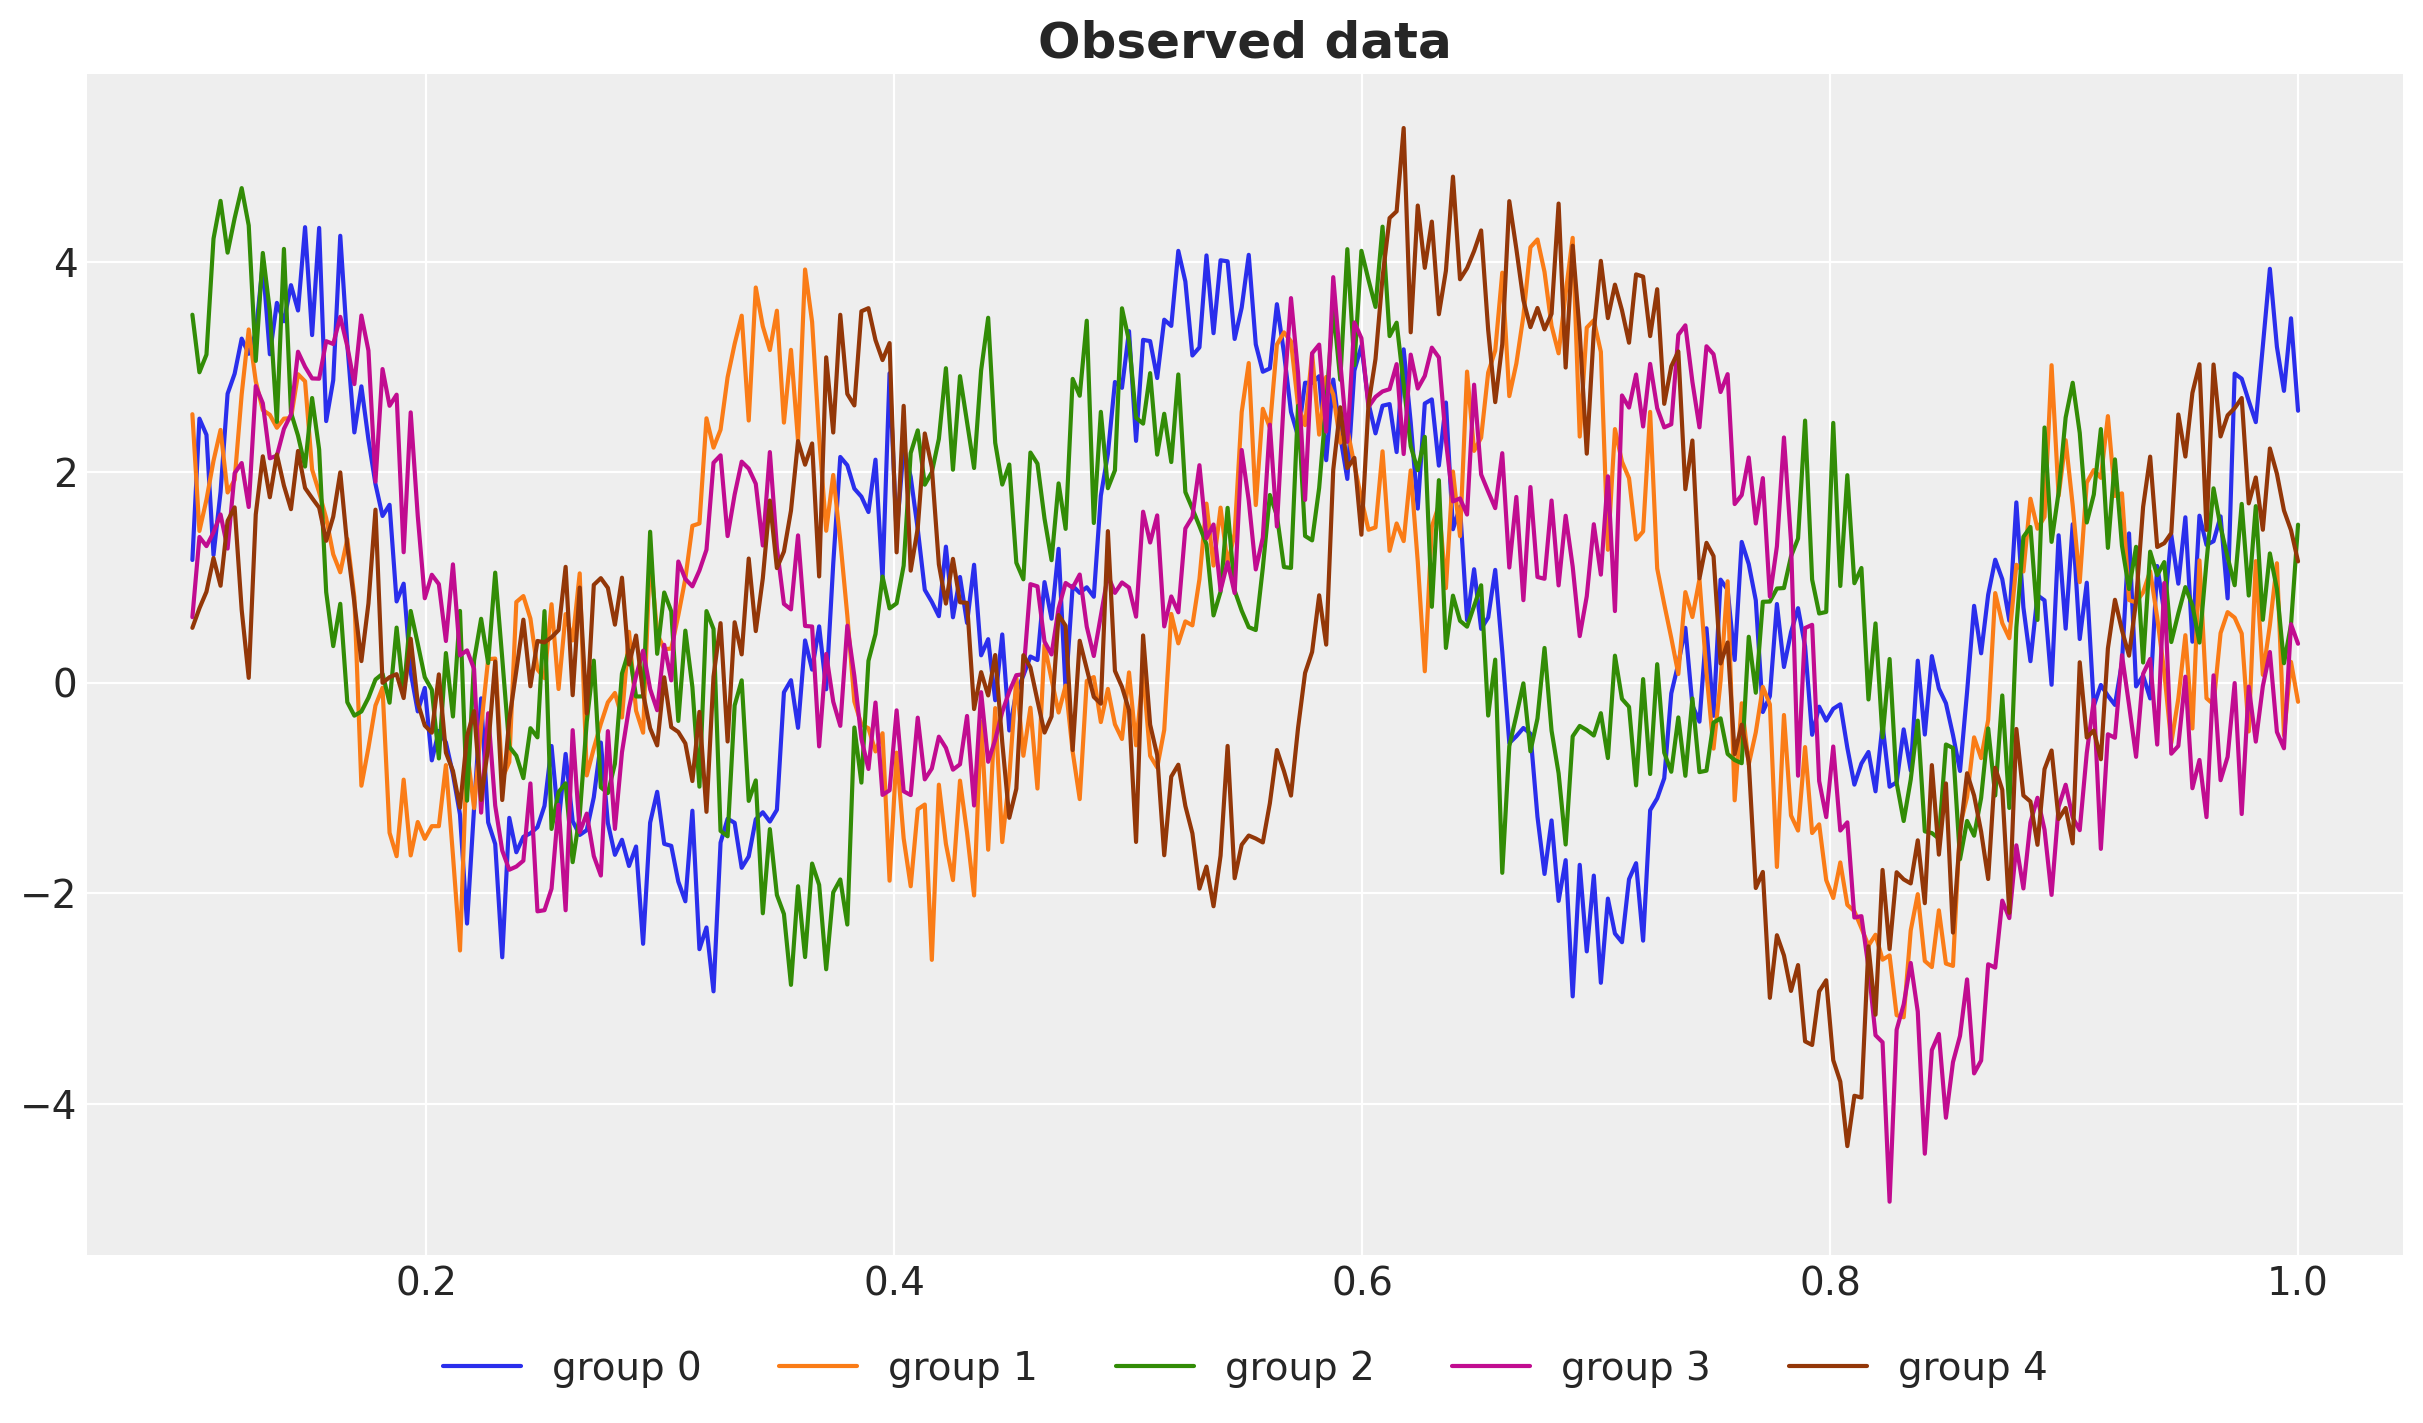

In [3]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x, y[g], c=f"C{g}", label=f"group {g}")

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups)
ax.set_title("Observed data", fontsize=18, fontweight="bold");

We see that each group has different dynamics, but they some how follow a global pattern. This hidden pattern is the latent mean function that we would like to recover using the hierarchical structure.

Next, let's visualize the group-specific latent functions.


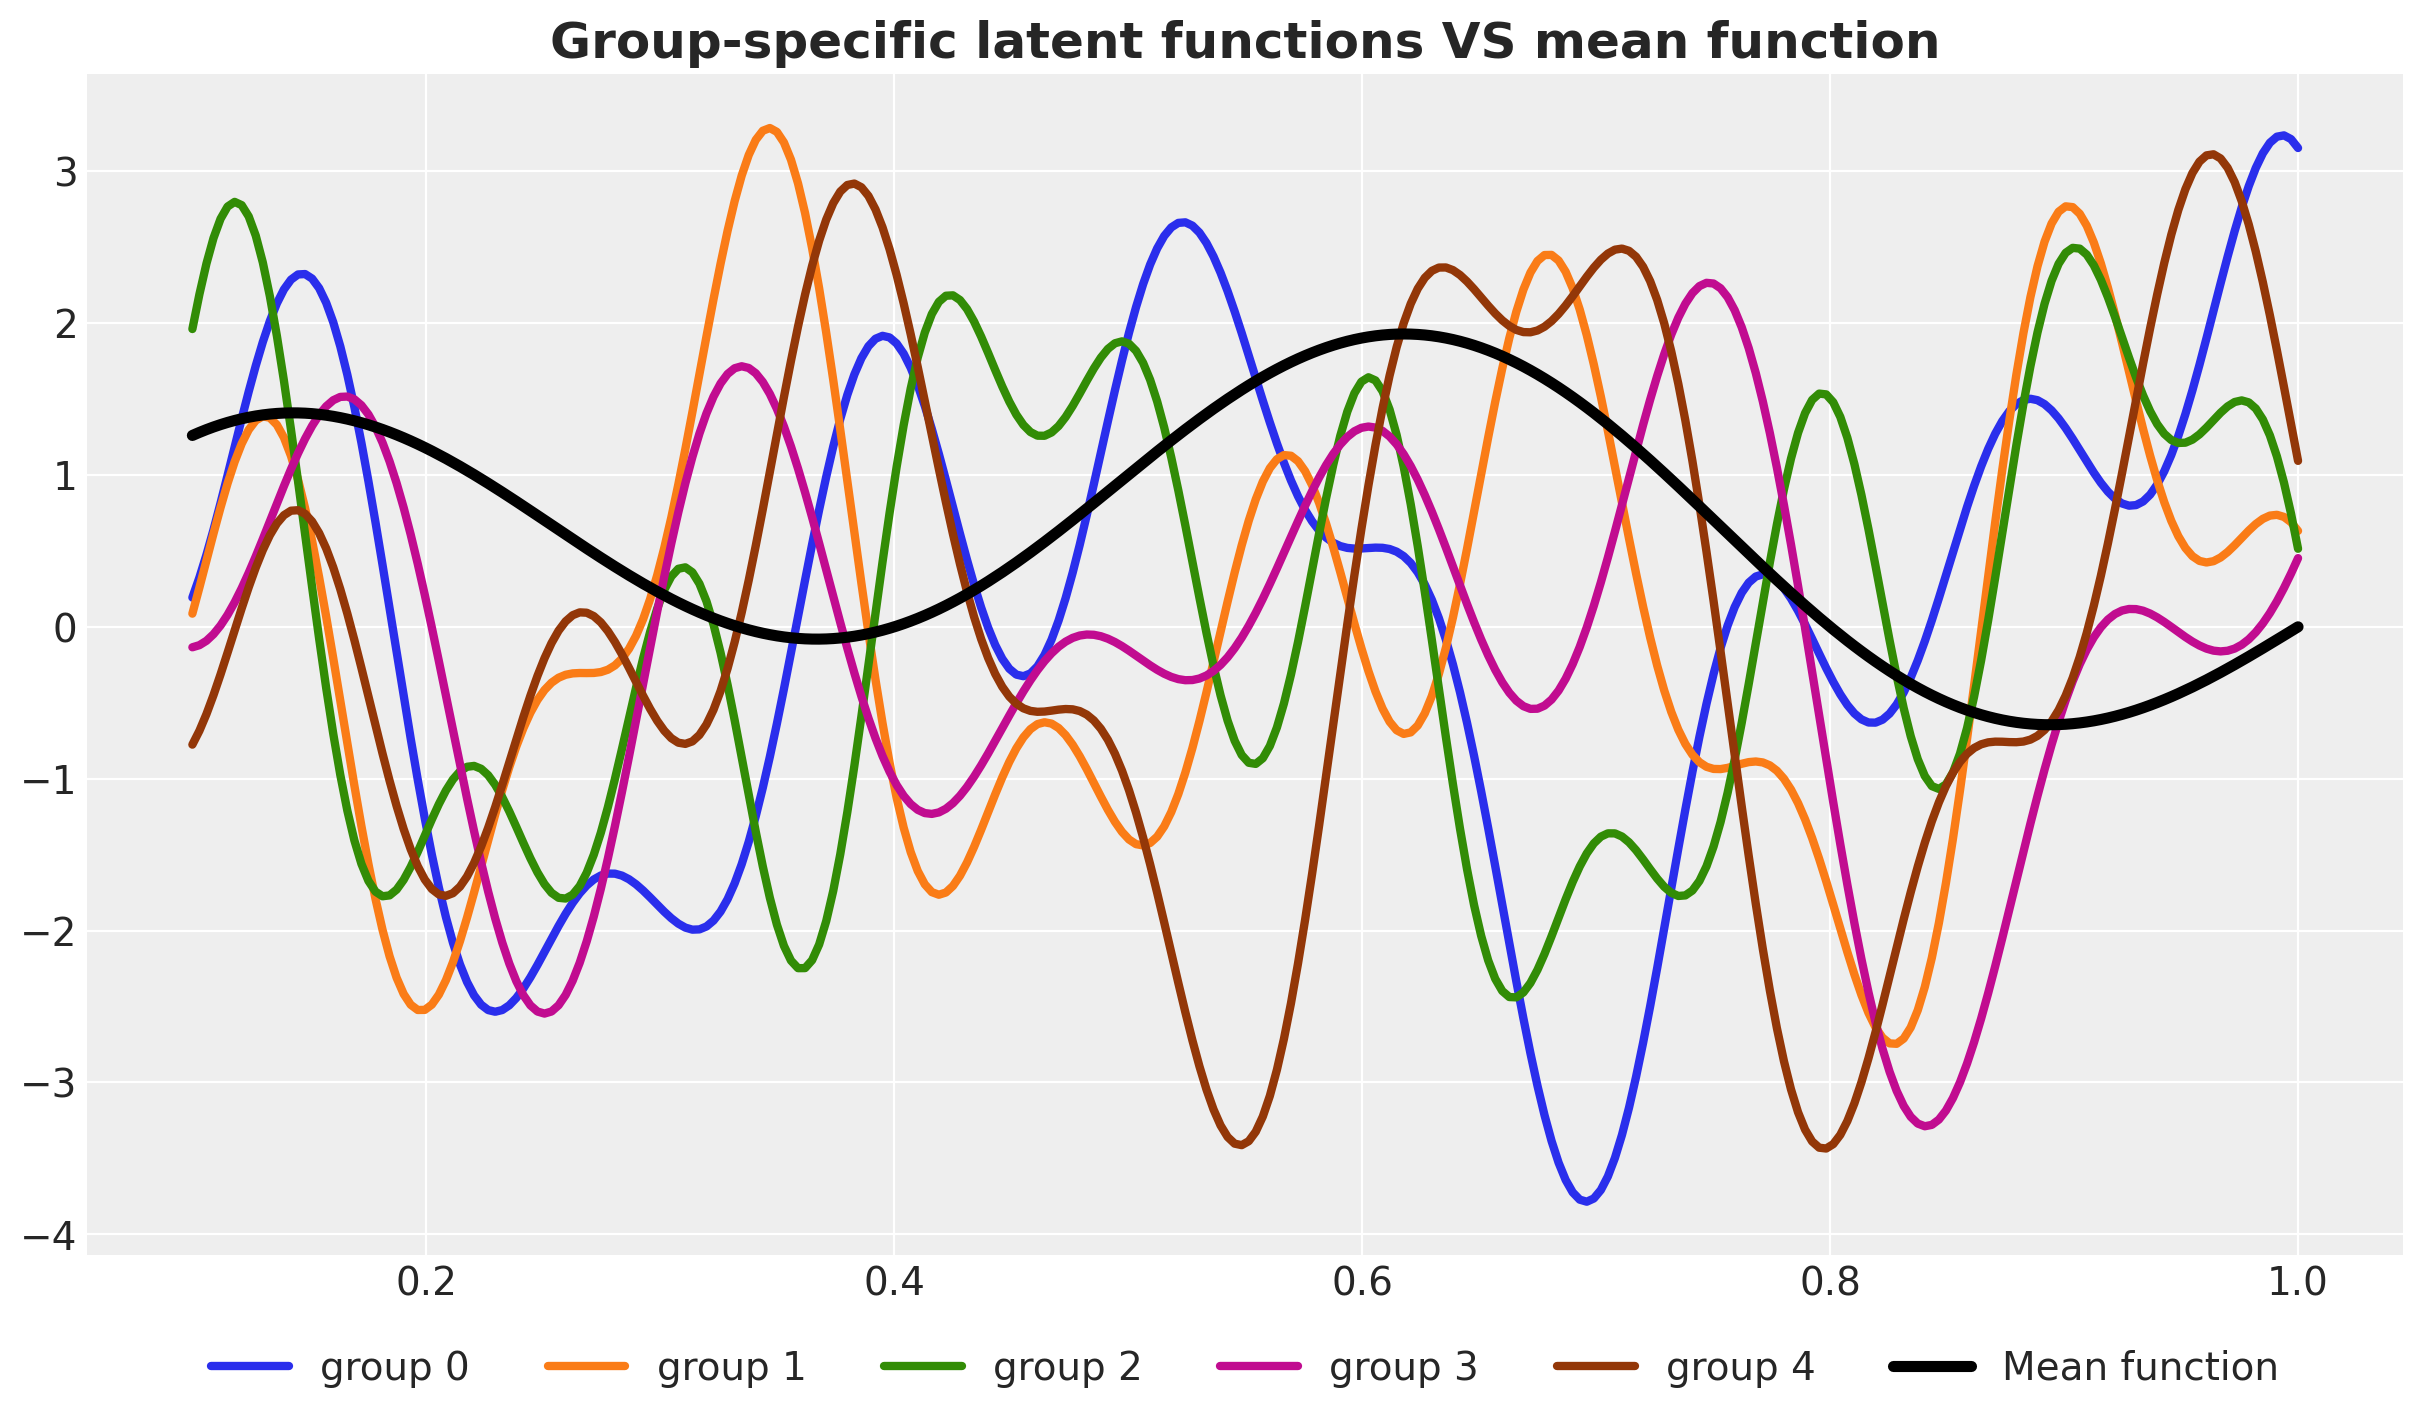

In [4]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x, f_g[g], lw=3, c=f"C{g}", label=f"group {g}")

ax.plot(x, f[0], c="black", lw=4, label="Mean function")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups + 1)
ax.set_title(
    "Group-specific latent functions VS mean function", fontsize=18, fontweight="bold"
);

Finally, let's look at everything together.

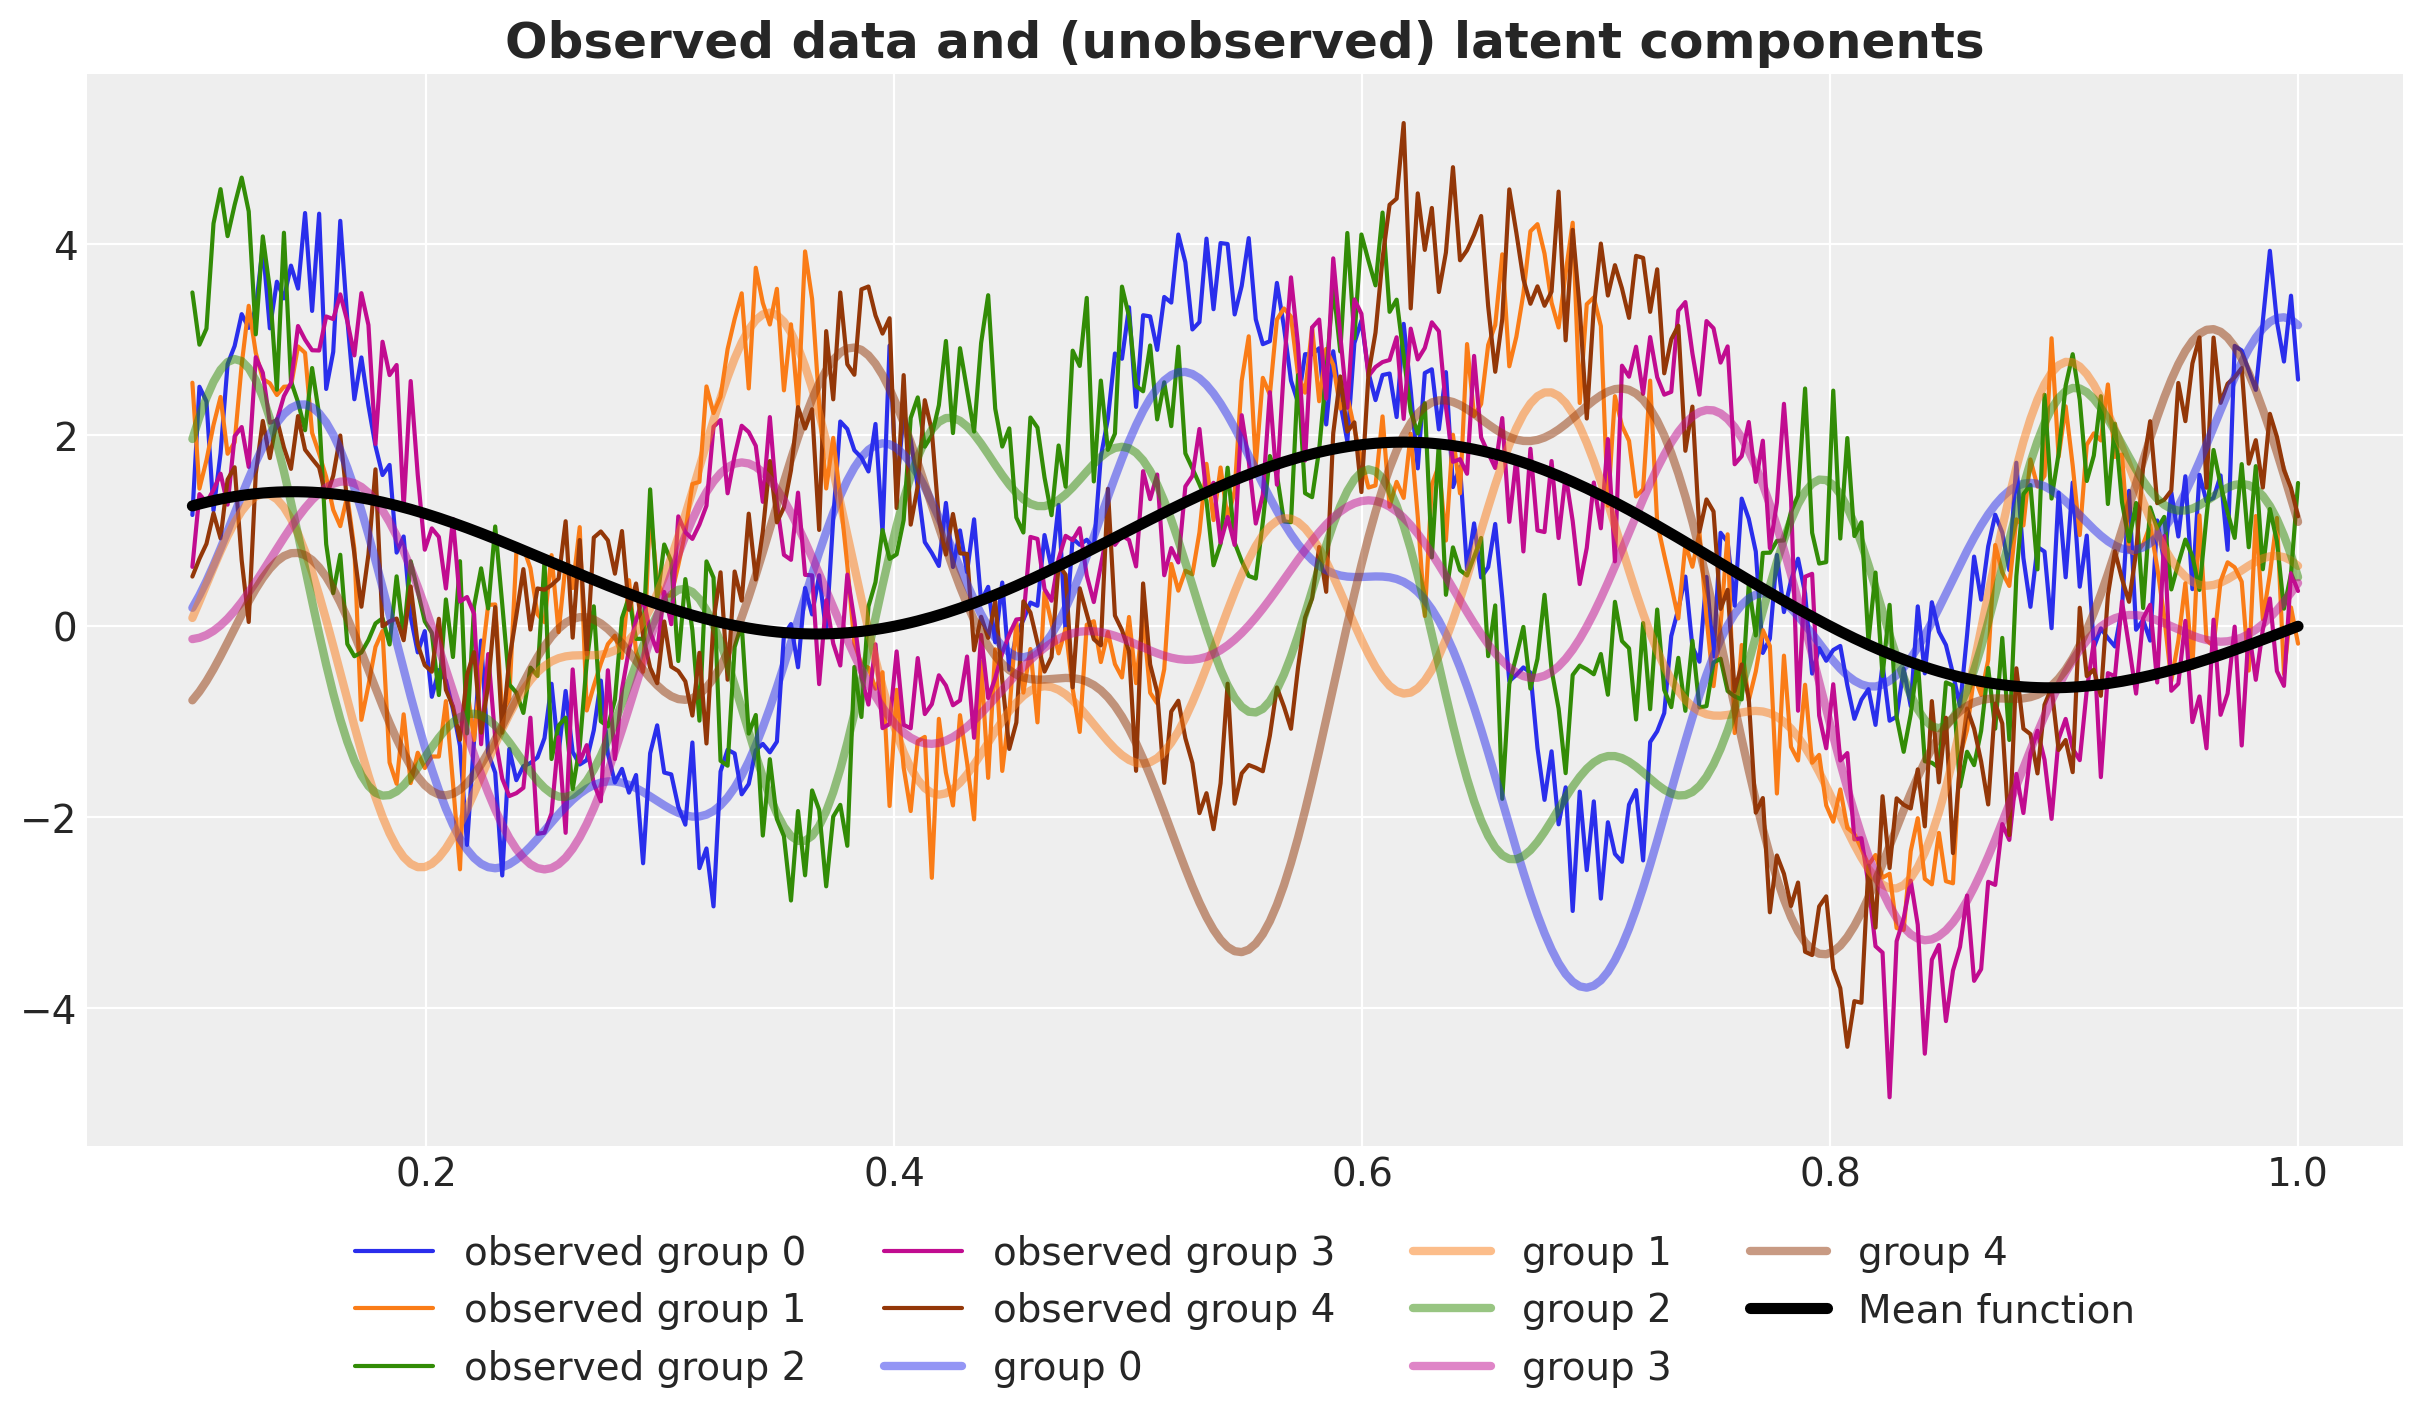

In [5]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x, y[g], c=f"C{g}", label=f"observed group {g}")

for g in range(n_groups):
    ax.plot(x, f_g[g], lw=3, c=f"C{g}", alpha=0.5, label=f"group {g}")

ax.plot(x, f[0], c="black", lw=4, label="Mean function")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups - 1)
ax.set_title(
    "Observed data and (unobserved) latent components", fontsize=18, fontweight="bold"
);

## Train Test Split

Next, we do a simple train/test split.

In [6]:
# Share of data to use for training
share_train = 0.85

# Number of training observations
n_train = int(n * share_train)

x_train = x[:n_train]
x_test = x[n_train:]

y_train = y[:, :n_train]
y_test = y[:, n_train:]

# Check shapes
assert x_train.shape == (n_train,)
assert x_test.shape == (n - n_train,)
assert y_train.shape == (n_groups, n_train)
assert y_test.shape == (n_groups, n - n_train)

We can visualize the train/test split result.

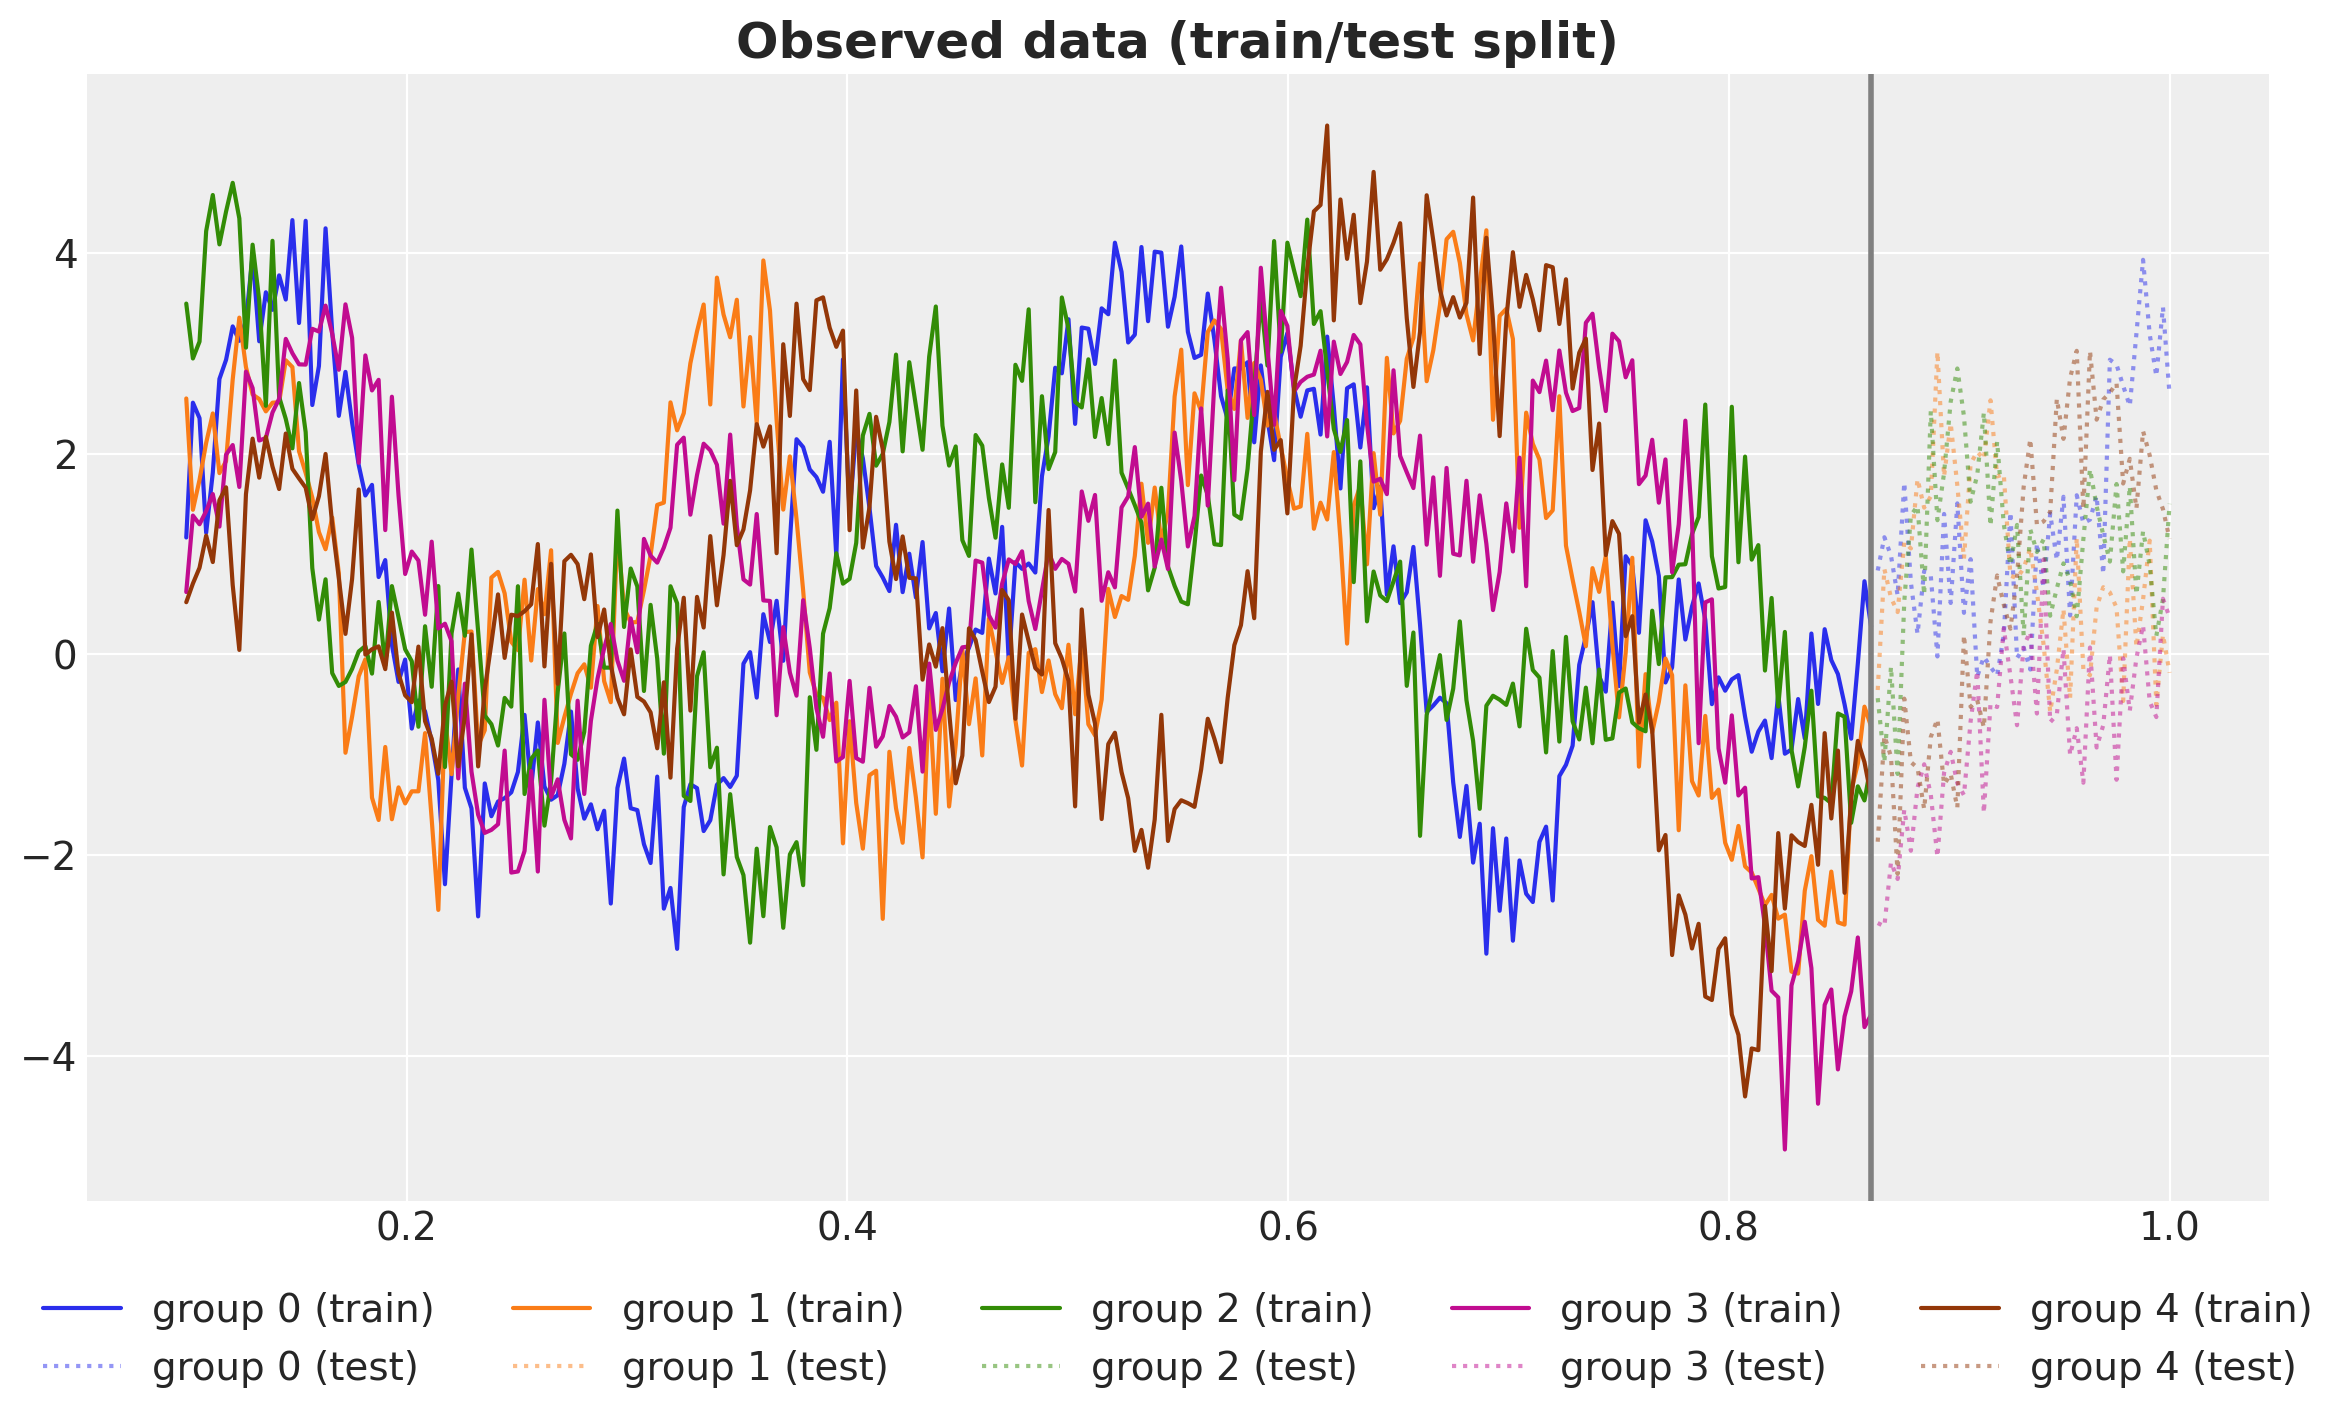

In [7]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x_train, y_train[g], c=f"C{g}", label=f"group {g} (train)")
    ax.plot(
        x_test, y_test[g], c=f"C{g}", ls="dotted", alpha=0.5, label=f"group {g} (test)"
    )

ax.axvline(x=x_train[-1], c="gray", lw=2)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups)
ax.set_title("Observed data (train/test split)", fontsize=18, fontweight="bold");

## Vectorized Spectral Density

As a reminder, the Hilbert Space Gaussian Process approximation is given by (see ["A Conceptual and Practical Introduction to Hilbert Space GPs Approximation Methods"](https://juanitorduz.github.io/hsgp_intro/) for a very complete explanation of the algorithm):

$$
f(x) \approx \sum_{j = 1}^{m} 
\overbrace{\color{red}{\left(S(\sqrt{\lambda_j})\right)^{1/2}}}^{\text{Spectral Density: all hyperparameters are here!}} 
\times
\underbrace{\color{blue}{\phi_{j}(x)}}_{\text{Eigenfunctions: easy to compute!}}
\times
\overbrace{\color{green}{\beta_{j}}}^{\sim \: \text{Normal}(0,1)}
$$

where 

- $S$ is the spectral density of the GP kernel. This in the only term that contains the hyperparameters of the GP kernel (amplitude and length scale).
- $(\phi_{j}(x), \lambda_{j})$ are the eigenfunctions and eigenvalues of the Dirichlet Laplacian operator on a unit hypercube.
- $\beta_{j}$ are the coefficients of the eigenfunction.

The spectral density expressions for the most used kernels are known and easy to implement. In many cases, and for most of the applications, the implementations are not fully vectorized to allow for many outputs. For our concrete application, we need to vectorize the spectral density expressions to allow for many groups. With JAX, this is straightforward using the [vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) function.

In [8]:
def diag_spectral_density_squared_exponential_vectorized(
    alpha: Float32[Array, " n_groups"],
    length: Float32[Array, " n_groups"],
    ell: float,
    m: int,
    dim: int,
) -> Float32[Array, " n_groups m"]:
    """Vectorized spectral density for the squared exponential kernel.

    Parameters
    ----------
    alpha : Float32[Array, " n_groups"]
        Amplitude parameter.
    length : Float32[Array, " n_groups"]
        Length parameter.
    ell : float
        Length scale.
    m : int
        Number of eigenfunctions.
    dim : int
        Dimension of the input space.
    """
    # Define the an array of parameters we want to vectorize over.
    theta = jnp.stack([alpha, length], axis=0)
    return vmap(
        lambda theta: diag_spectral_density_squared_exponential(
            alpha=theta[0],  # alpha,
            length=theta[1],  # length,
            ell=ell,
            m=m,
            dim=dim,
        ),
        in_axes=-1,
    )(theta)

Let's verify the implementation by computing the spectral density for different values of the hyperparameters:

- Constant of ones.
- Linear increasing.

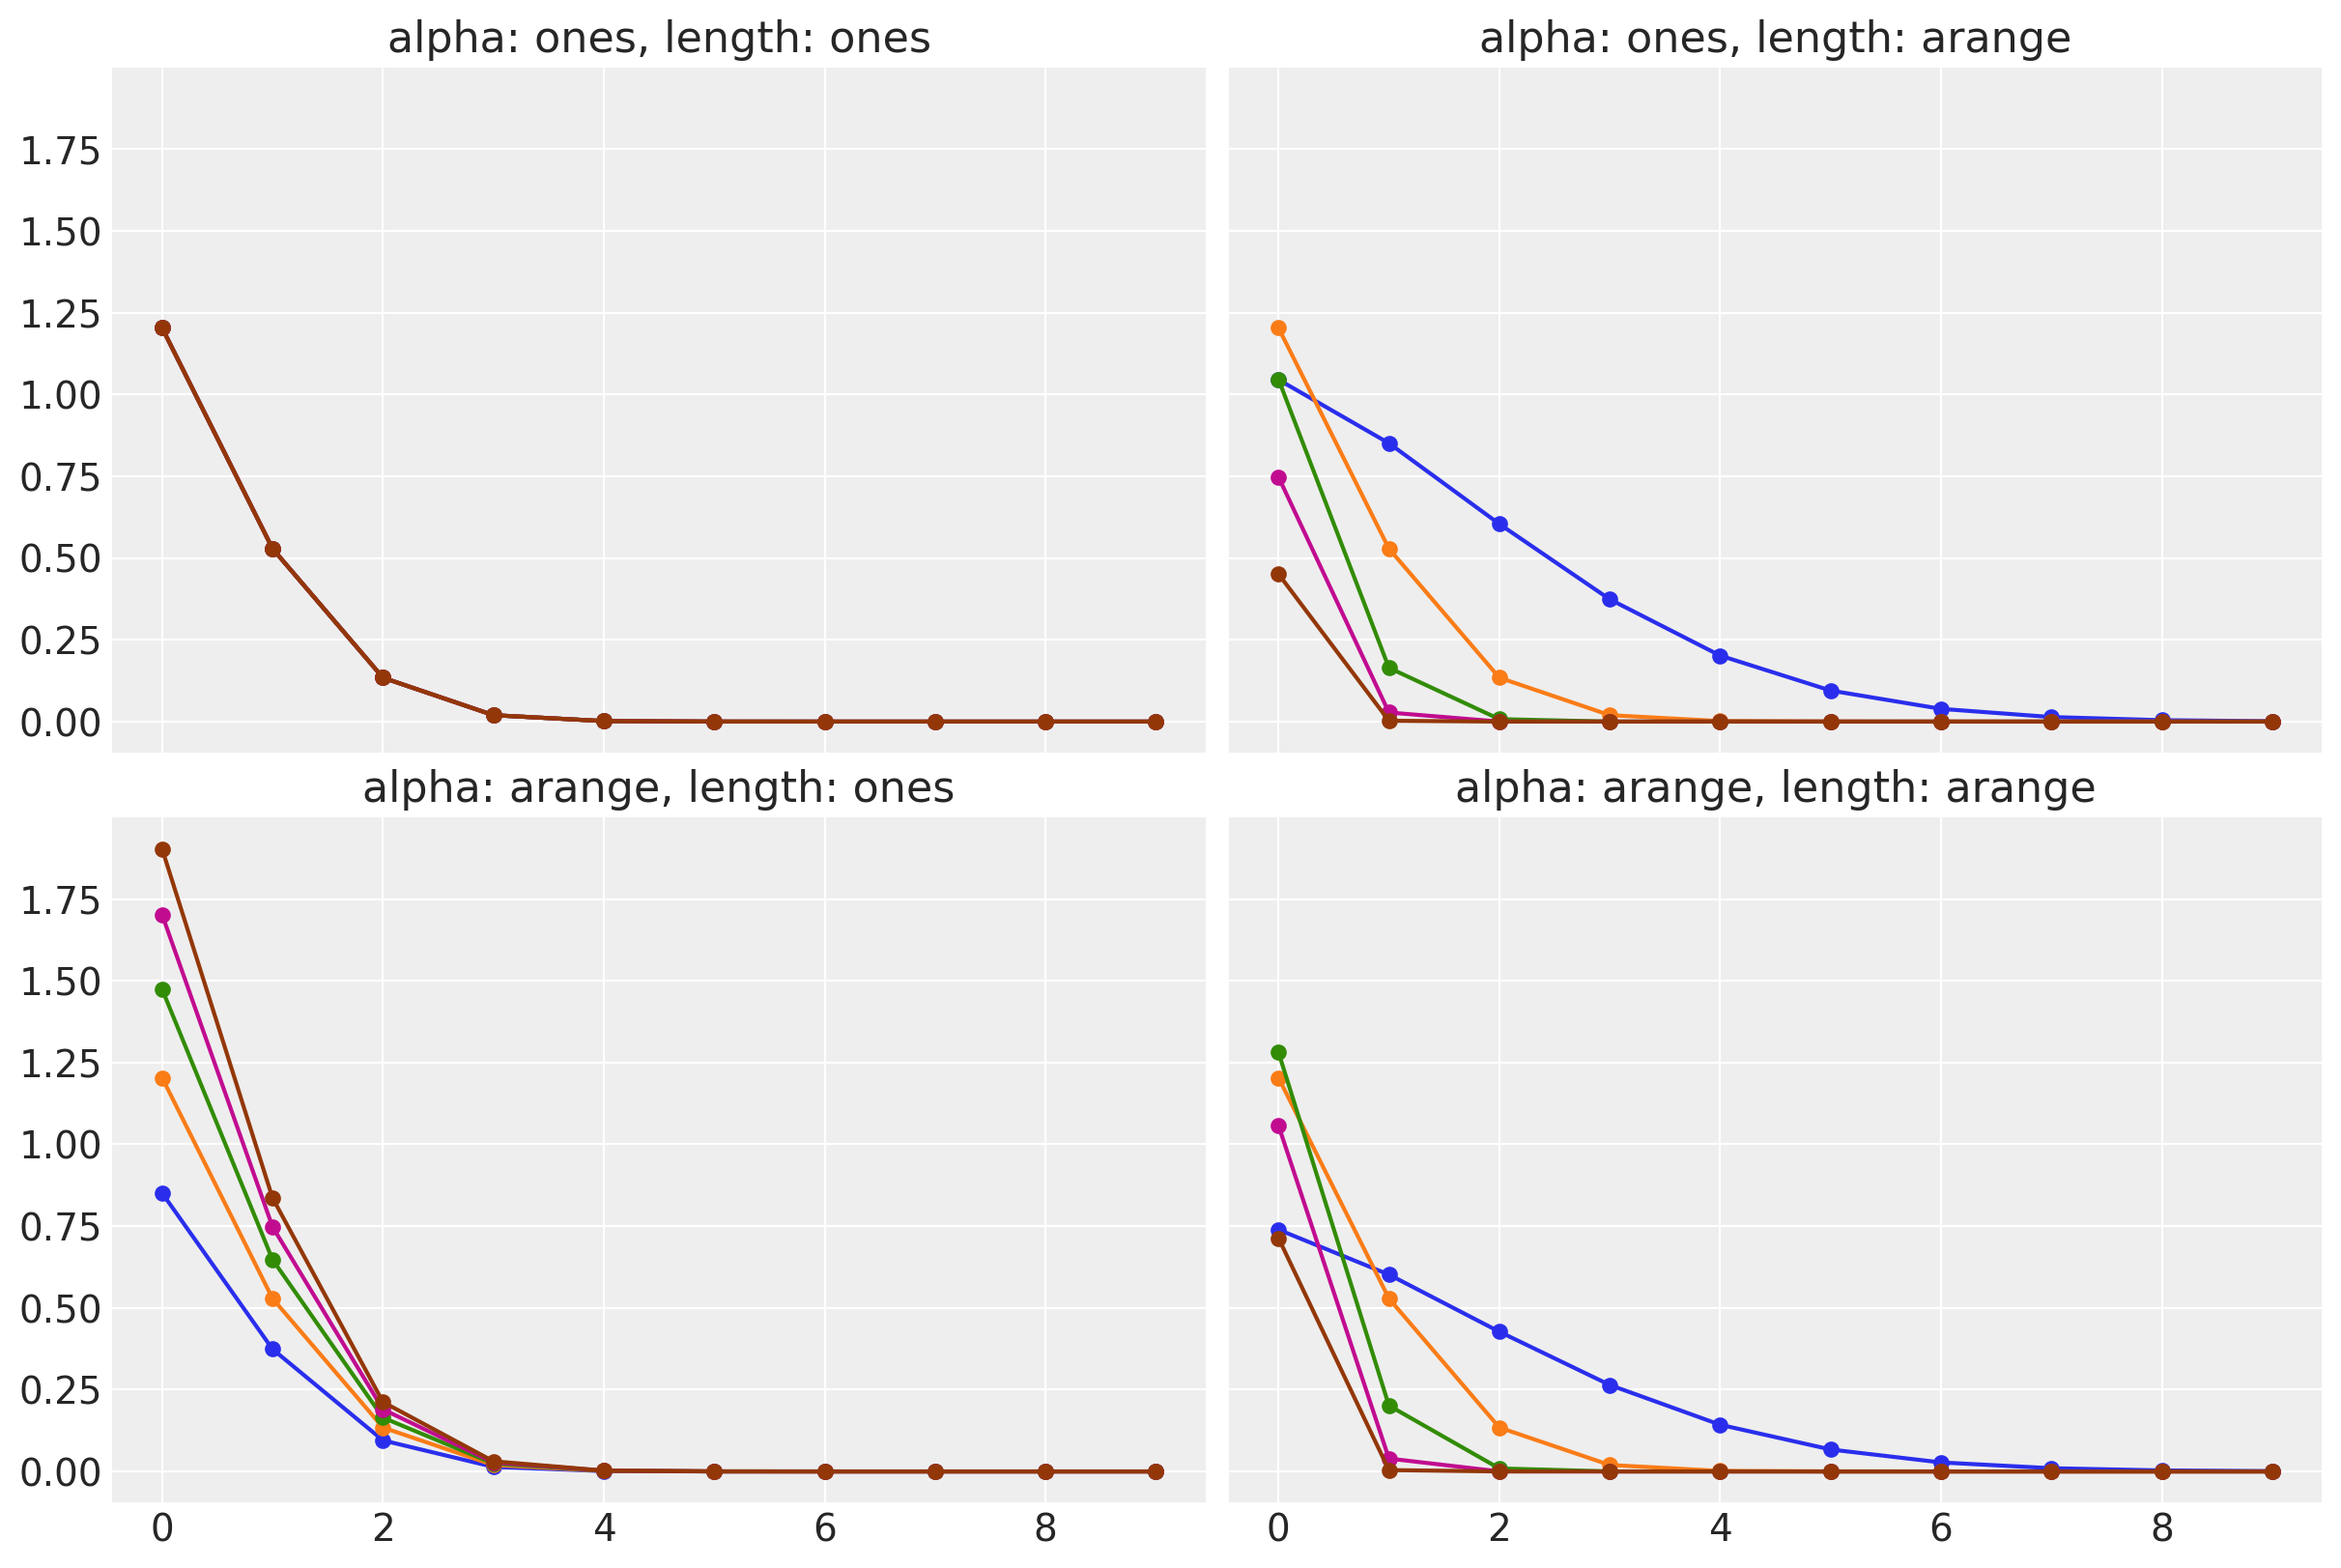

In [9]:
# Set fixed parameters
ell = 1.5
m = 10
dim = 1

# Set different values for the hyperparameters
## Constant of ones
ones_array = jnp.ones(n_groups)
## Linear increasing
arange_array = 0.5 * jnp.arange(start=1, stop=n_groups + 1, step=1)


fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=True, layout="constrained"
)

# Compute the spectral density for the different combinations of hyperparameters
for i, alpha in enumerate([ones_array, arange_array]):
    for j, length in enumerate([ones_array, arange_array]):
        spd = jnp.sqrt(
            diag_spectral_density_squared_exponential_vectorized(
                alpha=alpha,
                length=length,
                ell=ell,
                m=m,
                dim=dim,
            )
        )

        assert spd.shape == (n_groups, m)

        ax = axes[i, j]

        alpha_label = "ones" if i == 0 else "arange"
        length_label = "ones" if j == 0 else "arange"

        for g in range(n_groups):
            ax.plot(spd[g], c=f"C{g}", marker="o", markersize=5, label=f"group {g}")

        ax.set_title(f"alpha: {alpha_label}, length: {length_label}")

The results are as expected:

- In the upper left corner, we have the spectral density for a constant amplitude and length scale. All values of the spectral density are the same.
- In the upper right corner, we have the spectral density for a constant amplitude and a linear increasing length scale. All values of the spectral density are different. The smaller the length scale, the wider its "support".
- In the lower left corner, we have the spectral density for a linear increasing amplitude and length scale. All values of the spectral density are different. The smaller larger the amplitude, the larger the spectral density.
- In the lower right corner, we have the spectral density for a linear increasing amplitude and length scale. All values of the spectral density are different and consistent with the previous cases.

In addition, we can test this last case explicitly by testing the vectorization results against the scalar version.

In [10]:
# Compute the spectral density for the linear increasing amplitude and length scale.
spd = jnp.sqrt(
    diag_spectral_density_squared_exponential_vectorized(
        alpha=arange_array,
        length=arange_array,
        ell=ell,
        m=m,
        dim=dim,
    )
)

# Compare the vectorized results against the scalar version
for i, (single_alpha, single_length) in enumerate(
    zip(arange_array, arange_array, strict=True)
):
    assert jnp.array_equal(
        spd[i],
        jnp.sqrt(
            diag_spectral_density_squared_exponential(
                alpha=single_alpha, length=single_length, ell=ell, m=m, dim=dim
            )
        ),
    )

Everything works as expected!

## Model Specification

In [ ]:
alpha_prior, ax = pz.maxent(pz.InverseGamma(), lower=1, upper=5, mass=0.94)
ax.set_title("Alpha Prior", fontsize=18, fontweight="bold");

In [ ]:
length_prior, ax = pz.maxent(pz.InverseGamma(), lower=0.01, upper=1, mass=0.94)
ax.set_title("Length Prior", fontsize=18, fontweight="bold");

In [14]:
def model(x, y, ell, m_global, m_groups) -> None:
    n_groups, n_obs = y.shape

    log_alpha_global = numpyro.sample(
        "log_alpha_global", dist.Normal(loc=jnp.log(10), scale=2)
    )
    log_length_global = numpyro.sample(
        "log_length_global", dist.Normal(loc=jnp.log(0.05), scale=0.05)
    )

    log_alpha_groups = log_alpha_global + numpyro.sample(
        "log_alpha_groups", dist.ZeroSumNormal(scale=0.3, event_shape=(n_groups,))
    )
    log_length_groups = log_length_global + numpyro.sample(
        "log_length_groups", dist.ZeroSumNormal(scale=0.025, event_shape=(n_groups,))
    )

    alpha_global = numpyro.deterministic("alpha_global", softplus(log_alpha_global))
    length_global = numpyro.deterministic("length_global", softplus(log_length_global))

    alpha_groups = numpyro.deterministic("alpha_groups", softplus(log_alpha_groups))
    length_groups = numpyro.deterministic("length_groups", softplus(log_length_groups))

    nu = numpyro.sample("nu", dist.Gamma(concentration=10, rate=3))
    scale_prior = numpyro.sample("scale_prior", dist.HalfNormal(scale=2))

    with numpyro.plate("groups", n_groups, dim=-1):
        scale = numpyro.sample("scale", dist.HalfNormal(scale=scale_prior))

    phi = eigenfunctions(x=x, ell=ell, m=m_groups)

    f_global = numpyro.deterministic(
        "f_global",
        scope(hsgp_squared_exponential, prefix="global", divider="::")(
            x=x,
            alpha=alpha_global,
            length=length_global,
            ell=ell,
            m=m_global,
            non_centered=True,
        ),
    )

    spd = jnp.sqrt(
        diag_spectral_density_squared_exponential_vectorized(
            alpha=alpha_groups, length=length_groups, ell=ell, m=m_groups, dim=1
        )
    )

    with (
        numpyro.plate("groups", n_groups, dim=-1),
        numpyro.plate("basis", m_groups, dim=-2),
    ):
        beta_delta = numpyro.sample("beta_delta", dist.Normal(loc=0.0, scale=1.0))

    f_delta = numpyro.deterministic("f_delta", (phi @ (spd.T * beta_delta)).T)

    f_group = numpyro.deterministic("f_group", f_global + f_delta)

    numpyro.sample("obs", dist.StudentT(df=nu, loc=f_group, scale=scale[..., None]))

In [ ]:
ell = 1.5
m_global = 20
m_groups = 30

numpyro.render_model(model, model_args=(x_train, y_train, ell, m_global, m_groups))

## Prior Predictive Check

In [16]:
prior_predictive = Predictive(model, num_samples=2_000, return_sites=["obs"])

rng_key, rng_subkey = random.split(rng_key)
prior_predictive_samples = prior_predictive(
    rng_subkey, x_train, y_train, ell, m_global, m_groups
)

prior_predictive_idata = az.from_numpyro(
    prior=prior_predictive_samples,
    coords={"x": x_train, "group": jnp.arange(n_groups)},
    dims={"f": ["group", "x"], "obs": ["group", "x"]},
)

In [ ]:
fig, ax = plt.subplots()

for i, hdi_prob in enumerate([0.94, 0.5]):
    az.plot_hdi(
        x_train,
        prior_predictive_idata["prior"]["obs"].sel(group=0),
        fill_kwargs={
            "color": "gray",
            "alpha": 0.4 + 0.2 * i,
            "label": f"HDI {hdi_prob}",
        },
        hdi_prob=hdi_prob,
        smooth=True,
        ax=ax,
    )

for g in range(n_groups):
    ax.plot(x_train, y_train[g], c=f"C{g}", label=f"group {g}")

ax.axvline(x=x_train[-1], c="gray", lw=2)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups + 2)
ax.set_title("Prior predictive check", fontsize=18, fontweight="bold");

## Condition and Fit the Model

In [ ]:
conditioned_model = condition(model, data={"obs": y_train})

sampler = NUTS(conditioned_model, target_accept_prob=0.9)

mcmc = MCMC(sampler, num_warmup=1_500, num_samples=2_000, num_chains=4)

rng_key, rng_subkey = random.split(rng_key)
mcmc.run(rng_subkey, x_train, y_train, ell, m_global, m_groups)

In [19]:
idata = az.from_numpyro(
    posterior=mcmc,
    coords={
        "x": x_train,
        "group": jnp.arange(n_groups),
        "m_global": jnp.arange(m_global),
        "m_groups": jnp.arange(m_groups),
    },
    dims={
        "alpha_groups": ["group"],
        "length_groups": ["group"],
        "beta": ["m_global", "m_groups"],
        "beta_delta": ["m_groups", "group"],
        "f_delta": ["group", "x"],
        "f_global": ["x"],
        "f_group": ["group", "x"],
        "obs": ["group", "x"],
    },
)

## Model Diagnostics

In [ ]:
idata["sample_stats"].diverging.sum().item()

In [ ]:
az.summary(
    idata,
    var_names=[
        "log_alpha_global",
        "log_length_global",
        "log_alpha_groups",
        "log_length_groups",
        "scale_prior",
        "scale",
        "nu",
    ],
)

In [ ]:
_ = az.plot_trace(
    data=idata,
    var_names=[
        "log_alpha_global",
        "log_length_global",
        "log_alpha_groups",
        "log_length_groups",
        "alpha_global",
        "length_global",
        "alpha_groups",
        "length_groups",
        "scale_prior",
        "scale",
        "nu",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold");

## Posterior Predictive Check

In [23]:
posterior_predictive = Predictive(
    model, posterior_samples=mcmc.get_samples(), return_sites=["obs"]
)

rng_key, rng_subkey = random.split(rng_key)
posterior_predictive_samples = posterior_predictive(
    rng_subkey, x_train, y_train, ell, m_global, m_groups
)

idata.extend(
    az.from_numpyro(
        posterior_predictive=posterior_predictive_samples,
        coords={"x": x_train, "group": jnp.arange(n_groups)},
        dims={"f_group": ["group", "x"], "obs": ["group", "x"]},
    )
)

In [ ]:
fig, axes = plt.subplots(
    nrows=n_groups,
    ncols=1,
    figsize=(12, 3 * n_groups),
    sharex=True,
    sharey=True,
    layout="constrained",
)


for group in range(n_groups):
    for i, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            x_train,
            idata["posterior_predictive"]["obs"].sel(group=group),
            fill_kwargs={
                "color": f"C{group}",
                "alpha": 0.2 + 0.2 * i,
                "label": f"HDI {hdi_prob:.0%}",
            },
            hdi_prob=hdi_prob,
            smooth=True,
            ax=axes[group],
        )

    axes[group].plot(x_train, y_train[group], c=f"C{group}", label=f"group {group}")
    axes[group].legend(loc="lower left", ncol=3)

fig.suptitle("Posterior predictive check", fontsize=18, fontweight="bold");

In [ ]:
fig, ax = plt.subplots()
for i, hdi_prob in enumerate([0.94, 0.5]):
    az.plot_hdi(
        x_train,
        idata["posterior"]["f_global"],
        fill_kwargs={
            "color": "gray",
            "alpha": 0.4 + 0.2 * i,
            "label": f"HDI {hdi_prob:.0%}",
        },
        ax=ax,
        hdi_prob=hdi_prob,
        smooth=True,
    )
ax.plot(x, f[0], c="black", lw=4, label="Mean function")
ax.legend()

In [ ]:
fig, axes = plt.subplots(
    nrows=n_groups,
    ncols=1,
    figsize=(12, 3 * n_groups),
    sharex=True,
    sharey=True,
    layout="constrained",
)


for group in range(n_groups):
    for i, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            x_train,
            idata["posterior"]["f_delta"].sel(group=group),
            fill_kwargs={
                "color": f"C{group}",
                "alpha": 0.2 + 0.2 * i,
                "label": f"HDI {hdi_prob:.0%}",
            },
            hdi_prob=hdi_prob,
            smooth=True,
            ax=axes[group],
        )

    axes[group].plot(x, f_g[group], c=f"C{group}", label=f"group {group}")
    axes[group].legend(loc="lower left", ncol=3)

fig.suptitle("Posterior predictive check", fontsize=18, fontweight="bold");

## Out-of-Sample Prediction